# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

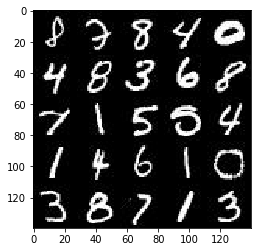

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

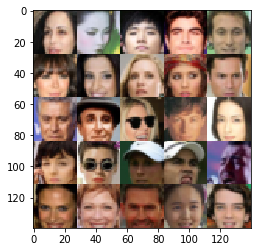

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [15]:
mnist_images[0].shape

(28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # input: (28, 28, 3)
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * images, images)
        # print(relu1.get_shape())

        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # print(relu2.get_shape())
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # print(relu3.get_shape())
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # label smoothing
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    (_, image_width, image_height, image_channels) = data_shape
    input_real, input_z, learning_rate_p = model_inputs(image_width, image_height, image_channels, z_dim)
    # print(input_real.get_shape())
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opts, g_opts = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    print_every=25
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                # From review:
                # Tanh output of the generator is between -1 and 1, 
                # so we have to normalize the input images to be between -1 and 1. 
                # The reason is that both the MNIST and CelebA datasets were normalized between -0.5 and 0.5. 
                # A possible implementation for the necessary change is to add batch_images *= 2.0 before both sess.run(). As a result, the generator will be able to generate more realistic images with a higher contrast.

                batch_images *= 2.0
                
                # from review: 
                # You can do a 2:3 ratio of running the discriminator and generator. 
                # To be more specific, you can run the generator three times and run the discriminator twice. 
                # This will yield better results due to the extra training steps for both the generator and discriminator
                
                _ = sess.run(d_opts, feed_dict={input_real: batch_images, input_z: batch_z })
                if steps % 3 != 0:
                    _ = sess.run(g_opts, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 1.4255
Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.5193
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 2.6232
Epoch 1/2... Discriminator Loss: 0.3877... Generator Loss: 3.1220


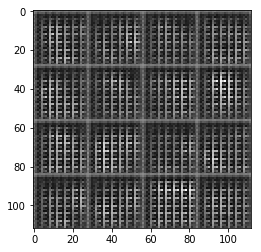

Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 2.3267
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.1920
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 2.2209
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.3200


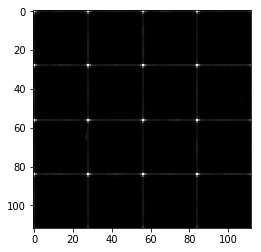

Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.9986
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.1654


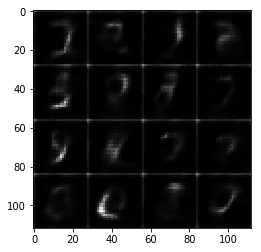

Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.8497


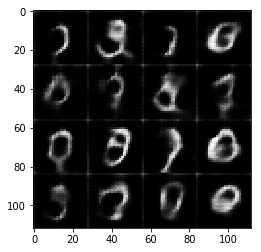

Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.9242


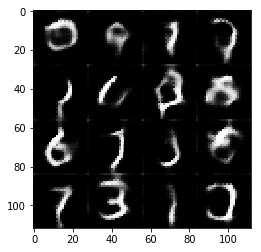

Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.0022


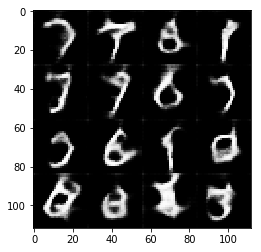

Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8292


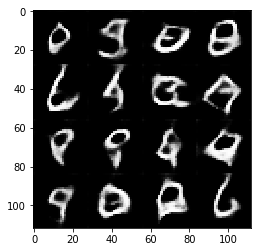

Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.8609


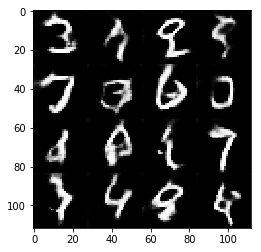

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.7755
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 1.0412


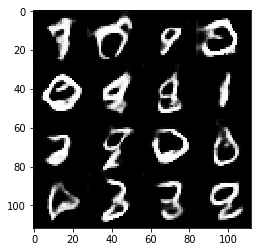

Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.9572
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.7640


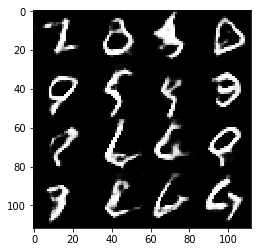

Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.8235


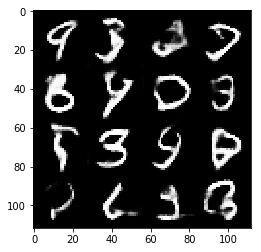

Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.9072
Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.9771


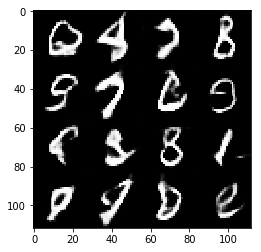

Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.8063


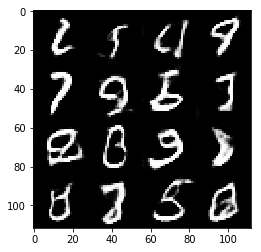

Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 1.1367
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.8611


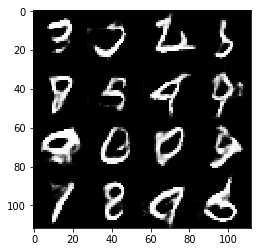

Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.0002


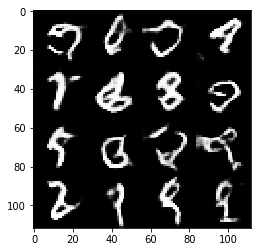

Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.8865
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.8185


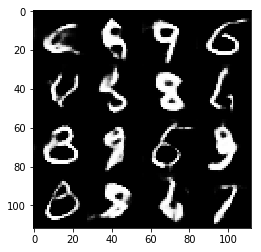

Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.9138


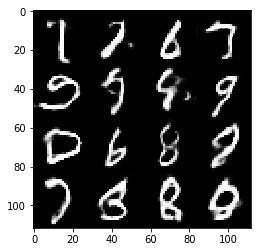

Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 1.1330


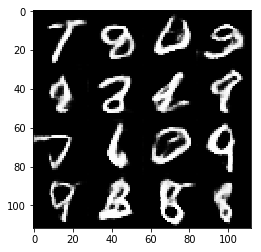

Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.8648


In [38]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1807


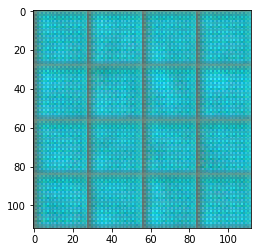

Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.4116


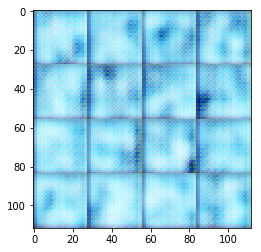

Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.9522
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.2291
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 2.5157


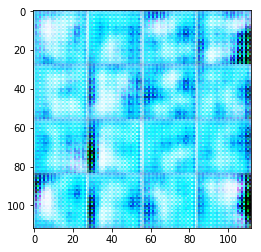

Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.9450
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.8707


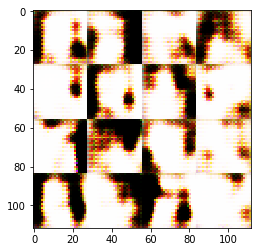

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.8148
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.9159


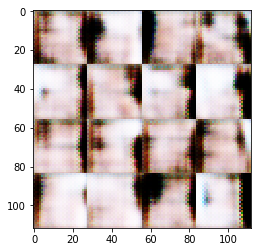

Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.7235
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.2227


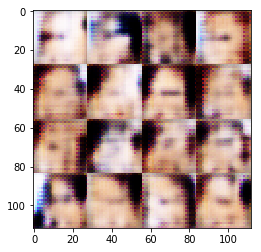

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9634


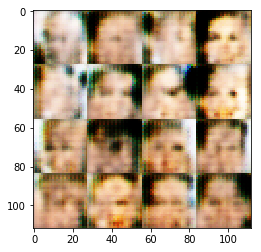

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8294


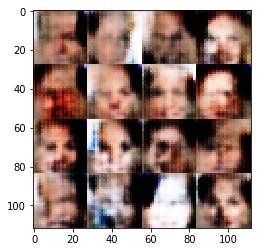

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.0051


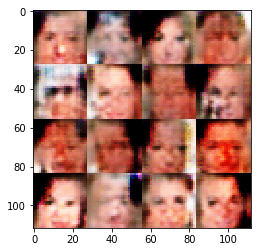

Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7527


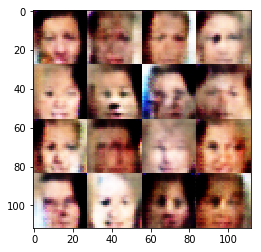

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7892


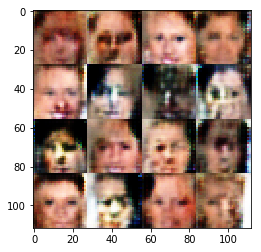

Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.9874


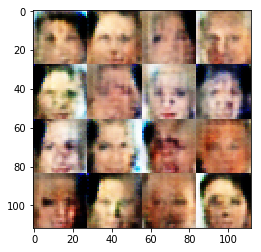

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7273


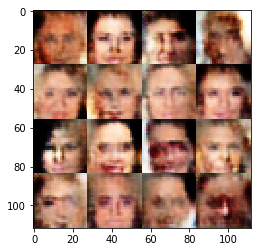

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7814


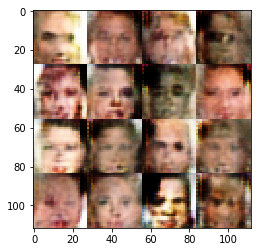

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.9024


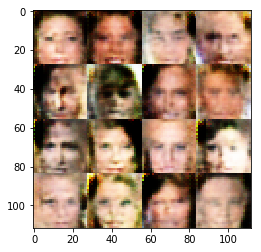

Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7783


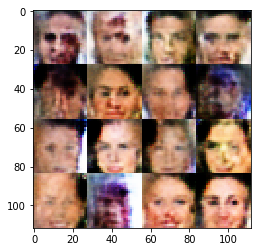

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7998


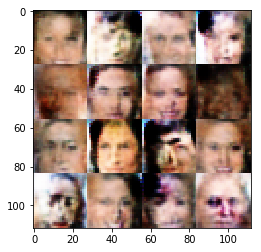

Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9917


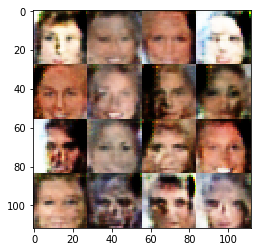

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7721


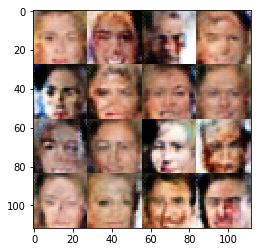

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7434


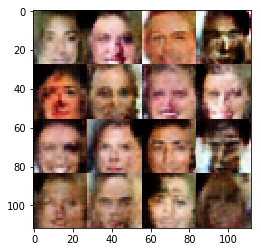

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9186


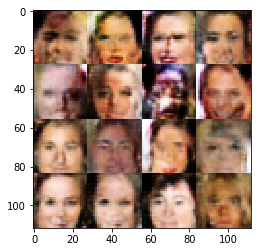

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7801


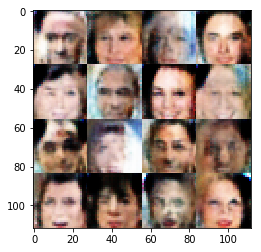

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7961


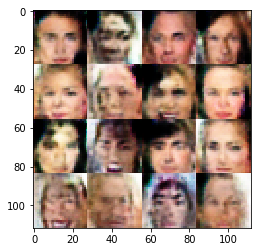

Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9589


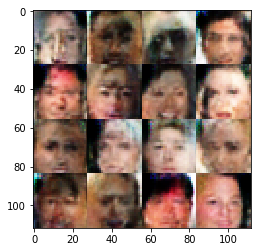

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7903


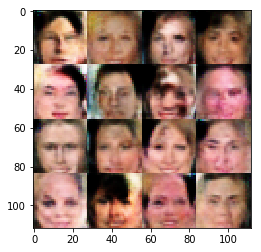

Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8116


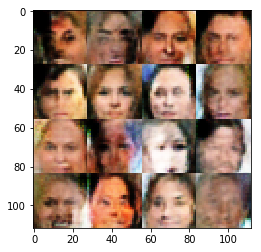

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.9046


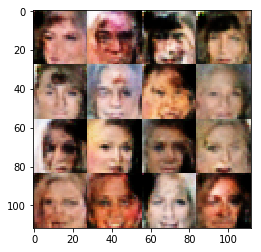

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8436


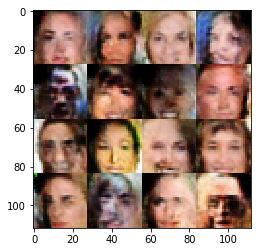

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7301


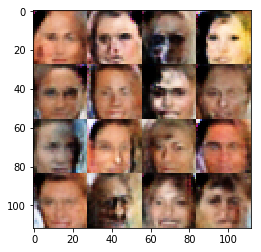

Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 1.0533


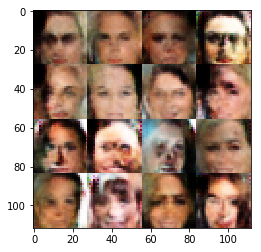

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6960


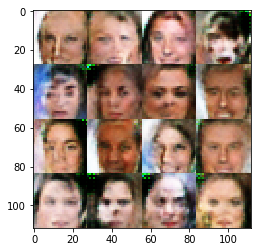

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.0660


In [39]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.